In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import sentencepiece as spm
import tensorflow_hub as hub
import bert

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os

import time

In [ ]:
import importlib
import src.models as model
importlib.reload(model)
import src.utils as util
importlib.reload(util);

In [ ]:
# Global data
data_path = "data/fra.txt"
data_raw= pd.read_table(data_path,names=['source', 'target', 'comments'])
data_raw.sample(5)

sample_size=60000
source, target = util.create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)


# en_sentence = u"May I borrow this book?"
# sp_sentence = u"¿Puedo tomar prestado este libro?"
# print(util.preprocess(en_sentence))
# print(util.preprocess(sp_sentence).encode('utf-8'))

In [18]:
# Bert Tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [19]:
def tokenize_bert(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

source_tokenizer = [tokenize_bert(ele) for ele in source]
source_tensor = source_tokenizer
print(source_tokenizer[0])

target_tokenizer = [tokenize_bert(ele) for ele in target]
target_tensor = target_tokenizer
print(target_tensor[0])

[2707, 1035, 2175, 1012, 1035, 2203]
[2707, 1035, 12436, 999, 1035, 2203]


In [20]:
# Create the source and target tokens and post pad them
source_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_tokenizer.fit_on_texts(source)
source_tensor = source_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post')

target_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_tokenizer.fit_on_texts(target)
target_tensor = target_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post')

max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)
print(source_tensor[0])

18
11
[ 1 39  3  2  0  0  0  0  0  0  0]


In [ ]:
# Creating training and validation sets using an 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(source_tensor, target_tensor, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Show length
print(len(X_train), len(y_train), len(X_val), len(y_val))
type(X_train)

In [ ]:
print ("Input Language; index to word mapping")
util.convert(source_tokenizer, X_train[0])
print ()
print ("Target Language; index to word mapping")
util.convert(target_tokenizer, y_train[0])

In [ ]:
# Create a tf.data dataset
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

In [ ]:
# Encorder
encoder = model.Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [ ]:
# Attention
attention_layer = model.BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [ ]:
# Decoder
decoder = model.Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [ ]:
# OptimizerCheckpoints (Object-based saving)
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += util.loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
# Training
print(steps_per_epoch)
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: start_ i am going to work at home . _end
Predicted translation: je vais travailler à la maison . _end 


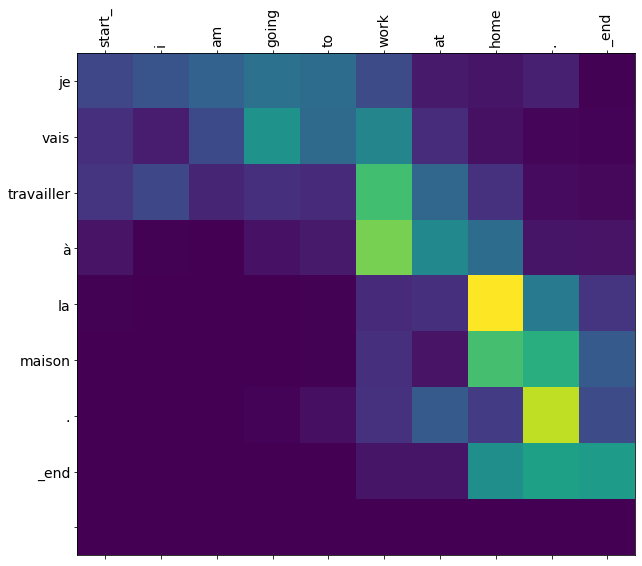

In [26]:
# translate(u'I am going to work.')
# translate(u'The project is super hard.')
util.translate(u'I am going to work at home.', units, max_target_length, max_source_length, encoder, decoder, source_tokenizer, target_tokenizer)